In [43]:
import torch
from torch import nn
import torchvision
import numpy as np
# import torchvision.datasets as Datasets
# from torch.utils.data import DataLoader, random_split
# from torchvision.transforms import ToTensor
# import torchvision.transforms as transforms
# import torchvision.utils as vutils

In [16]:
import numpy as no 
import matplotlib.pyplot as plt

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device", device, f"\n{torch.cuda.get_device_name(0)}")

Device cuda 
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [38]:
img_path = r"C:\\Users\\LENOVO\\Desktop\\HCU\\HCU3_2\\face recognition\\face_datasets"
img_size = 64
batch_size = 64
workers = 1

In [49]:
dataset = torchvision.datasets.ImageFolder(root=img_path,
                                          transform = torchvision.transforms.Compose([
                                              torchvision.transforms.Resize(img_size),
                                              torchvision.transforms.CenterCrop(img_size),
                                              torchvision.transforms.ToTensor()
                                          ]))

In [40]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=workers)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=workers
                                             )

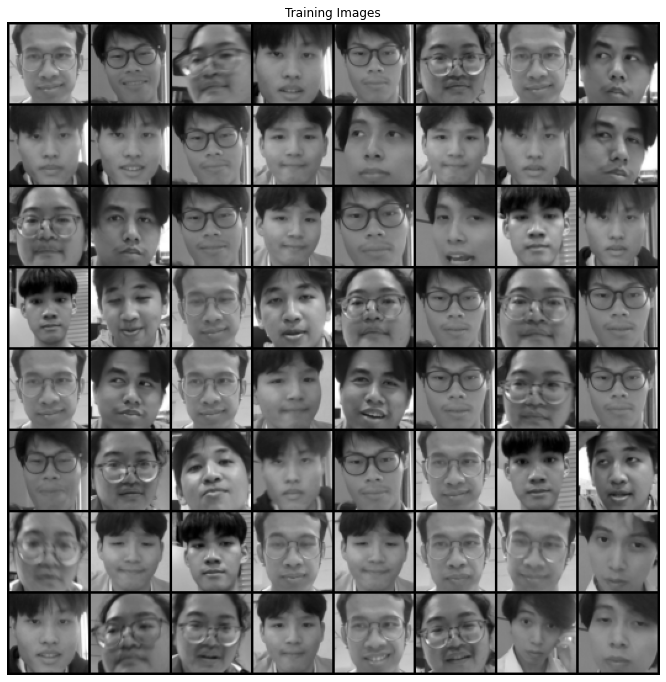

In [46]:
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [57]:
class Convert(nn.Module):
    def __init__(self):
        super(Convert, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            
            nn.Flatten(),
            nn.Linear(in_features=8192, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=9)
        )

    def forward(self, X):
        return self.network(X)

In [59]:
model = Convert().to(device)
print(model)

Convert(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=8192, out_features=64, bias=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=9, bias=True)
  )
)


In [75]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        # Compute prediction and Loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [76]:
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 10

for t in range(epochs):
    print(f"Epochs {t+1} \n------------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epochs 1 
------------------------------------
loss: 0.001105 [    0/ 3481]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000525 

Epochs 2 
------------------------------------
loss: 0.000296 [    0/ 3481]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001600 

Epochs 3 
------------------------------------
loss: 0.000198 [    0/ 3481]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000620 

Epochs 4 
------------------------------------
loss: 0.000015 [    0/ 3481]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000108 

Epochs 5 
------------------------------------
loss: 0.000054 [    0/ 3481]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000215 

Epochs 6 
------------------------------------
loss: 0.000029 [    0/ 3481]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000111 

Epochs 7 
------------------------------------
loss: 0.000034 [    0/ 3481]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025 

Epochs 8 
------------------------------------
loss: 0.000007 [    0/ 3481]
Test Error: 
 Accurac

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])
torch.Size([39, 3, 64, 64])
tensor([ 25.8948, -12.1415,   0.5064,  -2.0217,  -1.7609,   4.3141,  -2.5665,
          9.1398,   0.7064], device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')


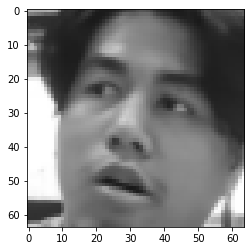

In [203]:
n = 12

with torch.no_grad():
    for X, y in test_dataloader:
        print(X.shape)
        X = X.to(device)
        y = y.to(device)
        pred = model(X)

predicted = pred[n]

print(predicted)
print(predicted.argmax(0), y[n])
plt.imshow(np.transpose(X[n].to("cpu"), (1, 2, 0)))
plt.show()

In [217]:
from PIL import Image

img_path = r"C:\Users\LENOVO\Pictures\Screenshots\test.png"

image = Image.open(img_path).convert('RGB')

image = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor()
])(image)

image = image.unsqueeze(0).to(device)
pred = model(image)
print(pred)

tensor([[ 4.2166, -6.5953, 15.0796, -9.4828,  0.7518, 11.1368, -7.6430, -1.2461,
          8.8265]], device='cuda:0', grad_fn=<AddmmBackward0>)
